### Module 3 - Model Training

This notebook contains only the generation of augmented data the training of model and the final results including train_accuracy, val_accuracy, test_accuracy, classification report and a confusion matrix.

**Model 1 : MobileNetV2_best1_notebook2.h5**

Validation Accuracy of Model 1 (recomputed): 85.00%

Training Accuracy of Model 1 (recomputed): 94.5238%

---

**Model 2 : MobileNetV2_best_notebook2.h5**

Validation Accuracy of Model 2 (From history): 86.67%

Training Accuracy of Model 2 (From history): 92.98%

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [21]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    "Dataset_split/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)


val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    "Dataset_split/val",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_generator = val_datagen.flow_from_directory(
    "Dataset_split/test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)



Found 840 images belonging to 4 classes.
Found 180 images belonging to 4 classes.
Found 180 images belonging to 4 classes.


In [22]:
NUM_CLASSES = train_generator.num_classes
print("Number of classes:", NUM_CLASSES)
print("Class indices:", train_generator.class_indices)


Number of classes: 4
Class indices: {'clear skin': 0, 'dark spots': 1, 'puffy eyes': 2, 'wrinkles': 3}


In [23]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [24]:
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False 

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=outputs)
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [26]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(
        monitor="val_accuracy",
        patience=5,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=3,
        min_lr=1e-6
    ),
    ModelCheckpoint(
        "MobileNetV2_best_notebook2.h5",
        monitor="val_accuracy",
        save_best_only=True
    )
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=callbacks
)


Epoch 1/30
27/27 [==============================] - 13s 463ms/step - loss: 0.6096 - accuracy: 0.7619 - val_loss: 0.6038 - val_accuracy: 0.7722 - lr: 1.0000e-04
Epoch 2/30
27/27 [==============================] - 11s 397ms/step - loss: 0.5799 - accuracy: 0.7976 - val_loss: 0.5659 - val_accuracy: 0.7833 - lr: 1.0000e-04
Epoch 3/30
27/27 [==============================] - 11s 404ms/step - loss: 0.5235 - accuracy: 0.8024 - val_loss: 0.5367 - val_accuracy: 0.8111 - lr: 1.0000e-04
Epoch 4/30
27/27 [==============================] - 11s 403ms/step - loss: 0.4604 - accuracy: 0.8333 - val_loss: 0.5231 - val_accuracy: 0.8111 - lr: 1.0000e-04
Epoch 5/30
27/27 [==============================] - 11s 409ms/step - loss: 0.4381 - accuracy: 0.8274 - val_loss: 0.5094 - val_accuracy: 0.8056 - lr: 1.0000e-04
Epoch 6/30
27/27 [==============================] - 11s 400ms/step - loss: 0.4182 - accuracy: 0.8464 - val_loss: 0.4964 - val_accuracy: 0.8056 - lr: 1.0000e-04
Epoch 7/30
27/27 [======================

In [27]:
print("Initial Training Results:\n")
best_val_acc = max(history.history['val_accuracy'])
best_epoch = history.history['val_accuracy'].index(best_val_acc) + 1
best_train_acc = max(history.history['accuracy'])
print(f"Best Validation Accuracy: {best_val_acc:.4f} at epoch {best_epoch}")
print(f"Best Training Accuracy: {best_train_acc:.4f}\n")            


Initial Training Results:

Best Validation Accuracy: 0.8667 at epoch 14
Best Training Accuracy: 0.9298



In [28]:
test_loss, test_acc = model.evaluate(test_generator)
print("Final Test Accuracy after initial training:", test_acc)

6/6 [==============================] - 1s 180ms/step - loss: 0.4290 - accuracy: 0.8667
Final Test Accuracy after initial training: 0.8666666746139526


In [ ]:
callbacks1 = [
    EarlyStopping(
        monitor="val_accuracy",
        patience=5,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=3,
        min_lr=1e-6
    ),
    ModelCheckpoint(
        "MobileNetV2_best3_notebook2.h5",
        monitor="val_accuracy",
        save_best_only=True
    )
]

In [30]:
base_model.trainable = False

# Freeze all except last 30 layers
for layer in base_model.layers[:-30]:
    layer.trainable = True


model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks1
)

best_val_acc = max(history_finetune.history["val_accuracy"])
print("Best Validation Accuracy after Fine-tuning:", best_val_acc)


Epoch 1/20
27/27 [==============================] - 35s 856ms/step - loss: 0.8251 - accuracy: 0.6857 - val_loss: 0.5314 - val_accuracy: 0.8167 - lr: 1.0000e-05
Epoch 2/20
27/27 [==============================] - 87s 3s/step - loss: 0.5976 - accuracy: 0.7643 - val_loss: 0.5127 - val_accuracy: 0.8000 - lr: 1.0000e-05
Epoch 3/20
27/27 [==============================] - 28s 1s/step - loss: 0.5361 - accuracy: 0.7798 - val_loss: 0.5061 - val_accuracy: 0.7889 - lr: 1.0000e-05
Epoch 4/20
27/27 [==============================] - 26s 966ms/step - loss: 0.4913 - accuracy: 0.8143 - val_loss: 0.5133 - val_accuracy: 0.8000 - lr: 1.0000e-05
Epoch 5/20
27/27 [==============================] - 27s 972ms/step - loss: 0.4242 - accuracy: 0.8369 - val_loss: 0.5011 - val_accuracy: 0.7889 - lr: 1.0000e-05
Epoch 6/20
27/27 [==============================] - 26s 954ms/step - loss: 0.4283 - accuracy: 0.8417 - val_loss: 0.5080 - val_accuracy: 0.8000 - lr: 1.0000e-05
Best Validation Accuracy after Fine-tuning: 0.

In [ ]:
class_weight = {
    0: 1.2,  
    1: 1.2,  
    2: 1.2,  
    3: 0.8   
}

callbacks2 = [
    EarlyStopping(
        monitor="val_accuracy",
        patience=5,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=3,
        min_lr=1e-6
    ),
    ModelCheckpoint(
        "MobileNetV2_best2_notebook2.h5",
        monitor="val_accuracy",
        save_best_only=True
    )
]

history_weighted = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=callbacks2,
    class_weight=class_weight
)


Epoch 1/5
27/27 [==============================] - ETA: 0s - loss: 0.3203 - accuracy: 0.8833

c:\Users\Kanishka\OneDrive\Desktop\AI_DermalScan\tf_env\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 19s 615ms/step - loss: 0.3203 - accuracy: 0.8833 - val_loss: 0.4456 - val_accuracy: 0.8500 - lr: 3.0000e-06
Epoch 2/5
27/27 [==============================] - 17s 615ms/step - loss: 0.3118 - accuracy: 0.9012 - val_loss: 0.4479 - val_accuracy: 0.8333 - lr: 3.0000e-06
Epoch 3/5
27/27 [==============================] - 16s 579ms/step - loss: 0.3053 - accuracy: 0.9012 - val_loss: 0.4497 - val_accuracy: 0.8222 - lr: 3.0000e-06
Epoch 4/5
27/27 [==============================] - 34s 1s/step - loss: 0.3169 - accuracy: 0.8881 - val_loss: 0.4510 - val_accuracy: 0.8167 - lr: 3.0000e-06
Epoch 5/5
27/27 [==============================] - 16s 602ms/step - loss: 0.3086 - accuracy: 0.9060 - val_loss: 0.4515 - val_accuracy: 0.8167 - lr: 1.0000e-06


In [35]:
#This model is the best model obtained after first training + fine-tuning 
#Validation Accuracy is 0.8500000238418579

from tensorflow.keras.models import load_model

model1 = load_model("MobileNetV2_best1_notebook2.h5")

test_loss, test_acc = model1.evaluate(test_generator)
print(f"Test Accuracy of the loaded model: {test_acc*100:.2f}%")

val_loss, val_acc = model1.evaluate(val_generator)
print(f"Validation Accuracy of the loaded model (recomputed): {val_acc*100:.2f}%")

train_loss, train_acc = model1.evaluate(train_generator)
print(f"Training Accuracy of the loaded model (recomputed): {train_acc*100:.4f}%")


6/6 [==============================] - 3s 197ms/step - loss: 0.4019 - accuracy: 0.8333
Test Accuracy of the loaded model: 83.33%
6/6 [==============================] - 1s 196ms/step - loss: 0.4451 - accuracy: 0.8500
Validation Accuracy of the loaded model (recomputed): 85.00%
27/27 [==============================] - 15s 548ms/step - loss: 0.2168 - accuracy: 0.9452
Training Accuracy of the loaded model (recomputed): 94.5238%


6/6 [==============================] - 3s 197ms/step
              precision    recall  f1-score   support

  clear skin       0.90      0.96      0.92        45
  dark spots       0.85      0.87      0.86        45
  puffy eyes       0.85      0.76      0.80        45
    wrinkles       0.74      0.76      0.75        45

    accuracy                           0.83       180
   macro avg       0.83      0.83      0.83       180
weighted avg       0.83      0.83      0.83       180



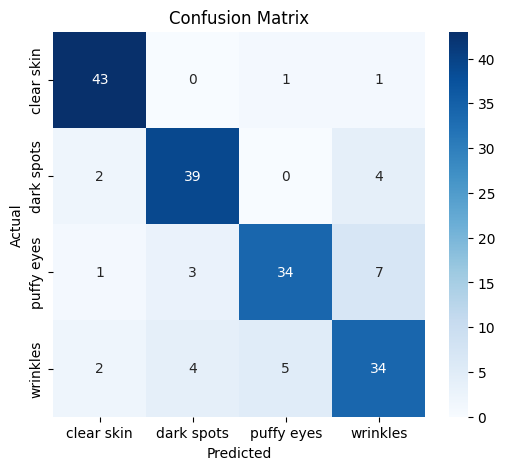

In [36]:
'''Classification Report and Confusion Matrix of First Model 
   (MobileNetV2_best1_notebook2.h5)'''

import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_probs = model1.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

from sklearn.metrics import classification_report

class_names = list(test_generator.class_indices.keys())

report = classification_report(
    y_true,
    y_pred,
    target_names=class_names
)
print(report)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


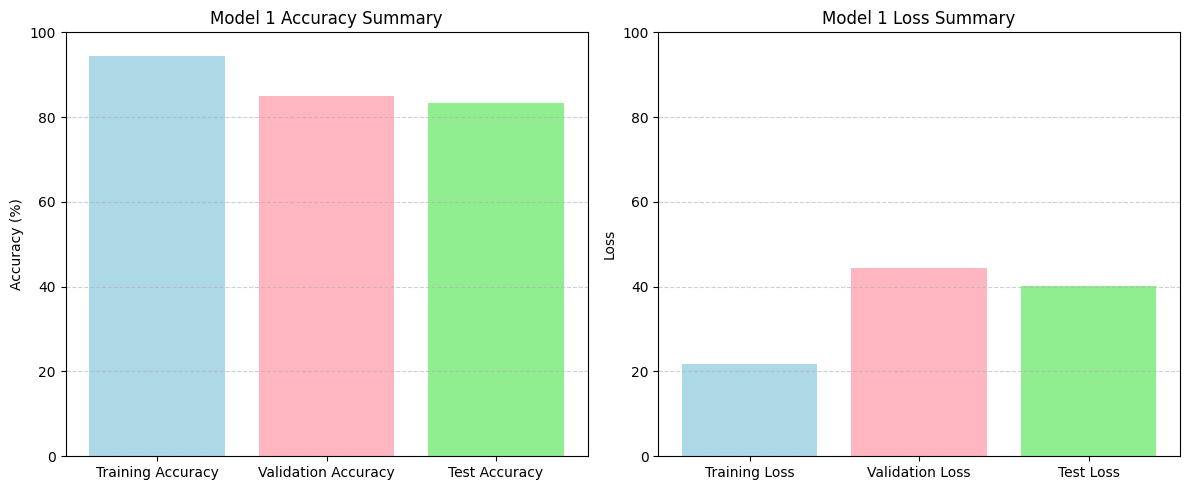

In [ ]:
#Values from recomputed evaluation of Model 1
model1_train_acc = 0.9452*100
model1_val_acc = 0.8500*100
model1_test_acc = 0.8333*100

model1_train_loss = 0.2168*100
model1_val_loss = 0.4451*100
model1_test_loss = 0.4019*100

labels = ["Training Accuracy", "Validation Accuracy", "Test Accuracy"]
values = [model1_train_acc, model1_val_acc, model1_test_acc]

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.bar(labels, values,color = ('lightblue', 'lightpink', 'lightgreen'))
plt.ylim(0, 100)
plt.ylabel("Accuracy (%)")
plt.title("Model 1 Accuracy Summary")
plt.grid(axis="y", linestyle="--", alpha=0.6)

labels = ["Training Loss", "Validation Loss", "Test Loss"]
values = [model1_train_loss, model1_val_loss, model1_test_loss]

plt.subplot(1,2,2)
plt.bar(labels, values, color = ('lightblue', 'lightpink', 'lightgreen'))
plt.ylim(0, 100)
plt.ylabel("Loss")
plt.title("Model 1 Loss Summary")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [38]:
#This model is the best model obtained after the second training from scratch
#Validation Accuracy is 0.8666666746139526

from tensorflow.keras.models import load_model

model2 = load_model("MobileNetV2_best_notebook2.h5")

test_loss, test_acc = model2.evaluate(test_generator)
print(f"Test Accuracy of the loaded model: {test_acc*100:.2f}%")

print(f"Validation Accuracy of the loaded model: {max(history.history['val_accuracy'])*100:.2f}%")

print(f"Training Accuracy of the loaded model: {max(history.history['accuracy'])*100:.2f}%")

6/6 [==============================] - 3s 214ms/step - loss: 0.4290 - accuracy: 0.8667
Test Accuracy of the loaded model: 86.67%
Validation Accuracy of the loaded model: 86.67%
Training Accuracy of the loaded model: 92.98%


6/6 [==============================] - 3s 201ms/step
              precision    recall  f1-score   support

  clear skin       0.96      0.96      0.96        45
  dark spots       0.91      0.89      0.90        45
  puffy eyes       0.85      0.78      0.81        45
    wrinkles       0.76      0.84      0.80        45

    accuracy                           0.87       180
   macro avg       0.87      0.87      0.87       180
weighted avg       0.87      0.87      0.87       180



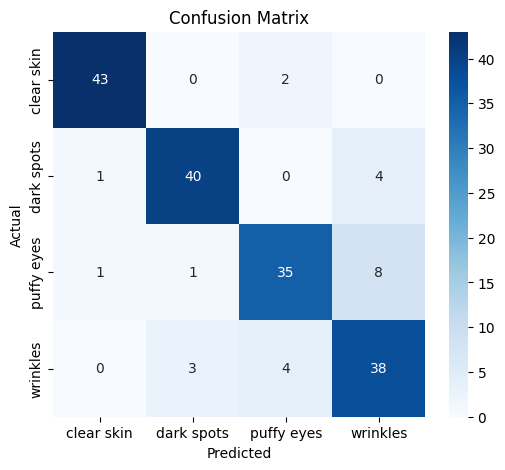

In [39]:
'''Classification Report and Confusion Matrix of Second Model 
   (MobileNetV2_best_notebook2.h5)'''

import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_probs = model2.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

from sklearn.metrics import classification_report

class_names = list(test_generator.class_indices.keys())

report = classification_report(
    y_true,
    y_pred,
    target_names=class_names
)
print(report)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


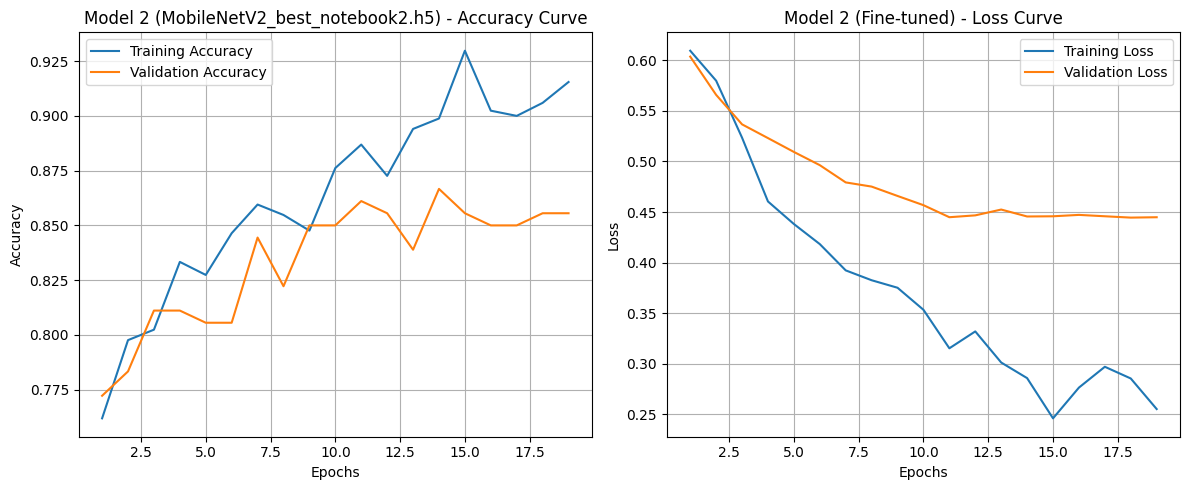

In [ ]:
# Accuracy and loss values
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(12,5))

# Accuracy Curve
plt.subplot(1,2,1)
plt.plot(epochs, train_acc, label="Training Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model 2 (MobileNetV2_best_notebook2.h5) - Accuracy Curve")
plt.legend()
plt.grid(True)

# Loss Curve
plt.subplot(1,2,2)
plt.plot(epochs, train_loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model 2 (MobileNetV2_best_notebook2.h5) - Loss Curve")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
